`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

1) Входной слой (batch картинок HxWxC) C - color chanel (3=RGB)
   Batch -  количество образцов, которые будут распространены по сети. После каждой итерации 
   обучения batch параметры нейронной сети обновляются

<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

непосредственно, сама архитектура нейросети (сюда входят типы функций активации у каждого нейрона);
начальная инициализация весов каждого слоя;
метод оптимизации нейросети (сюда ещё входит метод изменения learning_rate);
размер батчей (batch_size);
количетсво итераций обучения (num_epochs);
функция потерь (loss);
тип регуляризации нейросети (для каждого слоя можно свой);

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch .utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [87]:
class SpecDataset(Dataset):
    def __init__(self, root, csv_file, transform=None):
        self.root = root
        self.date = pd.read_csv(csv_file, index_col=0).iloc[:,0]
        self.class_name = pd.read_csv(csv_file, index_col=0).iloc[:,2]
        self.transform = transform

    def get_fpath(self, index):
        """ Create an image file path """
        dt = pd.to_datetime(self.date[index], format='%Y-%m-%d %H:%M:%S')
        fpath = dt.strftime('cp0_flare_%Y%m%dT%H_%M_%S.fits')
        
        return fpath


    def normalize(self, spec):
        """ Do np.array normalization """
        spec_min = np.amin(spec)
        spec_max = np.amax(spec)
        spec_norm = np.zeros(shape=spec.shape)
     
        for i, arr in enumerate(spec):
            temp = (arr - spec_min)/(spec_max-spec_min)
            spec_norm[i] = temp
    
        return spec_norm
    
    def read_file(self, index):
        """ Read FITS file. Return an image of SRH spectrum """
        fpath = self.get_fpath(index)
        dat = fits.open(self.root + fpath)
        spec = dat[0].data.astype(np.float32)

        spec_norm = self.normalize(spec)
        spec_norm = spec_norm.astype(np.float32)
        
        return spec_norm
    
    def __len__(self):
        return len(self.date)

    def __getitem__(self, index):
        spec = self.read_file(index)
        label = self.class_name[index]
        
        if self.transform:
            spec = self.transform(spec)
        
        return (spec, label) 
        

In [88]:
root = 'data/cross_spec_2023/'
csv_file = 'dataset/cross_spec_0.csv'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((50, 50))
                               ])

dataset = SpecDataset(root, csv_file, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])

(tensor([[[0.5744, 0.5739, 0.5743,  ..., 0.5742, 0.5740, 0.5732],
          [0.5744, 0.5742, 0.5746,  ..., 0.5734, 0.5734, 0.5728],
          [0.5745, 0.5739, 0.5738,  ..., 0.5727, 0.5728, 0.5729],
          ...,
          [0.5765, 0.5757, 0.5754,  ..., 0.5759, 0.5766, 0.5755],
          [0.5767, 0.5747, 0.5750,  ..., 0.5755, 0.5758, 0.5727],
          [0.5779, 0.5751, 0.5770,  ..., 0.5761, 0.5762, 0.5764]]]),
 'non-burst')

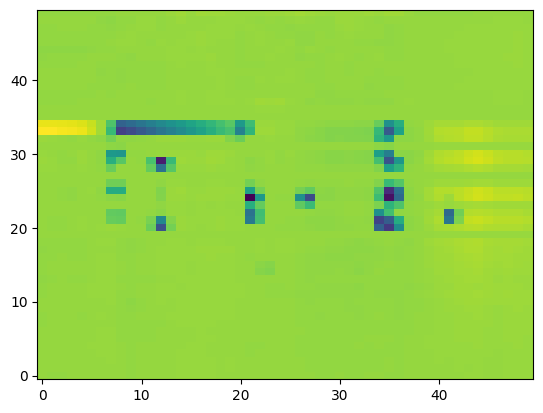

In [89]:
plt.figure()
plt.imshow(train_dataset[0][0][0], aspect='auto', origin='lower')
train_dataset.__getitem__(1)

In [37]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [38]:
for batch in train_loader:
    print(batch)

[tensor([[[[0.5987, 0.6042, 0.5983,  ..., 0.6006, 0.6004, 0.6040],
          [0.5983, 0.6001, 0.5990,  ..., 0.6028, 0.5993, 0.6012],
          [0.5941, 0.5965, 0.5992,  ..., 0.6013, 0.5976, 0.6028],
          ...,
          [0.6009, 0.6187, 0.6177,  ..., 0.6021, 0.6100, 0.6180],
          [0.5959, 0.6052, 0.6190,  ..., 0.5982, 0.5967, 0.6075],
          [0.6023, 0.6201, 0.6036,  ..., 0.5863, 0.5898, 0.5929]]],


        [[[0.5092, 0.5117, 0.5126,  ..., 0.5143, 0.5146, 0.5129],
          [0.5144, 0.5145, 0.5144,  ..., 0.5152, 0.5141, 0.5123],
          [0.5176, 0.5169, 0.5166,  ..., 0.7552, 0.7819, 0.7987],
          ...,
          [0.5251, 0.5237, 0.5176,  ..., 0.5172, 0.5211, 0.5135],
          [0.5241, 0.5155, 0.5253,  ..., 0.5263, 0.5262, 0.5193],
          [0.5280, 0.5134, 0.5348,  ..., 0.5404, 0.5274, 0.5227]]],


        [[[0.6789, 0.6933, 0.6019,  ..., 0.5986, 0.5439, 0.5873],
          [0.7006, 0.7076, 0.6300,  ..., 0.5776, 0.5321, 0.5677],
          [0.6786, 0.7135, 0.6491,  .

FileNotFoundError: [Errno 2] No such file or directory: 'data/cross_spec_2023/cp0_flare_20230908T09_11_34.fits'

In [8]:
import torch.nn as nn
import torch.nn.functional as F 

In [14]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net = SimpleConvNet()
summary(net.cpu(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [34]:
batch = []
batch = next(iter(train_loader))

# net.forward(batch[0]).cpu()
test = torch.FloatTensor(batch[0])

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=double, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))